In [10]:
from pathlib import Path
from typing import List
import pandas as pd
from pandas import DataFrame

import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
sns.set()
sns.set(rc={'figure.figsize':(40,25)})
sns.set(font_scale=8)

In [22]:
SCHEMA: str = "Schema"
TABLE_NAME: str = "Table"
COLUMN_NAME: str = "Column"
DATA_TYPE: str = "Data Type"
COUNT: str = "Number of Columns"
CS_DATA_TYPE: str = "CS Data Type"
OPERATOR: str = "Operator"
EXECUTION_COUNT: str = "Execution Count"

data_path: Path = Path("../data/")

### Processing

In [23]:
def plot_stacked(data: DataFrame, x: str, y: str, hue: str, hue_order: List[str]=None):
    df_plottable: DataFrame = data.groupby([x, hue])[y].sum().reset_index().pivot(columns=hue, index=x, values=y)
    if hue_order:
        assert sorted(hue_order) == sorted(list(df_plottable))
        df_plottable = df_plottable[hue_order]
    df_plottable.plot(kind="bar", stacked=True)
    plt.ylabel(y)

def load_data(path: Path, tables_filter: List[str]) -> DataFrame:
    SAP_data: DataFrame = pd.read_csv(path, header=None, sep=",", error_bad_lines=False)
    SAP_data = SAP_data.rename(columns={1: SCHEMA,
                                2: TABLE_NAME,
                                4: COLUMN_NAME,
                                7: DATA_TYPE,
                                8: COUNT,
                                18: CS_DATA_TYPE}, errors="raise")
    filtered_by_scheme: DataFrame = SAP_data[SAP_data[SCHEMA] == "SAPISP"]
    grouped_by_column: DataFrame = filtered_by_scheme\
        .groupby([DATA_TYPE, COLUMN_NAME, TABLE_NAME, CS_DATA_TYPE], as_index=False)[COUNT].count()
    only_valid_tables: DataFrame = grouped_by_column[grouped_by_column[TABLE_NAME].isin(tables_filter)]
    return only_valid_tables

path: Path = data_path / "data.csv"

isp_plan_analyses: DataFrame = pd.read_csv(data_path / 'isp.csv')
plan_executions = pd.read_csv(data_path / 'plan_execution_counts.csv')
column_accesses = pd.merge(isp_plan_analyses, plan_executions)
column_accesses = column_accesses.rename(columns={"OBJECT_NAME": TABLE_NAME, "COLUMN_NAME": COLUMN_NAME,
                                                  "USAGE": OPERATOR, "EXECUTION_COUNT": EXECUTION_COUNT})
tables: List[str] = column_accesses[TABLE_NAME].unique()
SAP_data: DataFrame = load_data(path, tables)

b'Skipping line 2937727: expected 37 fields, saw 38\n'
b'Skipping line 3073097: expected 37 fields, saw 39\n'
b'Skipping line 3084376: expected 37 fields, saw 39\nSkipping line 3087083: expected 37 fields, saw 39\n'
b'Skipping line 3100565: expected 37 fields, saw 39\nSkipping line 3103761: expected 37 fields, saw 39\nSkipping line 3103764: expected 37 fields, saw 39\n'
/Users/linusheinzl/Documents/Semester2/DatabaseSystems/column-compression/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (12,14,25,30,35) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [14]:
with_type_info: DataFrame = pd.merge(column_accesses, SAP_data,on=[TABLE_NAME, COLUMN_NAME])

### Results

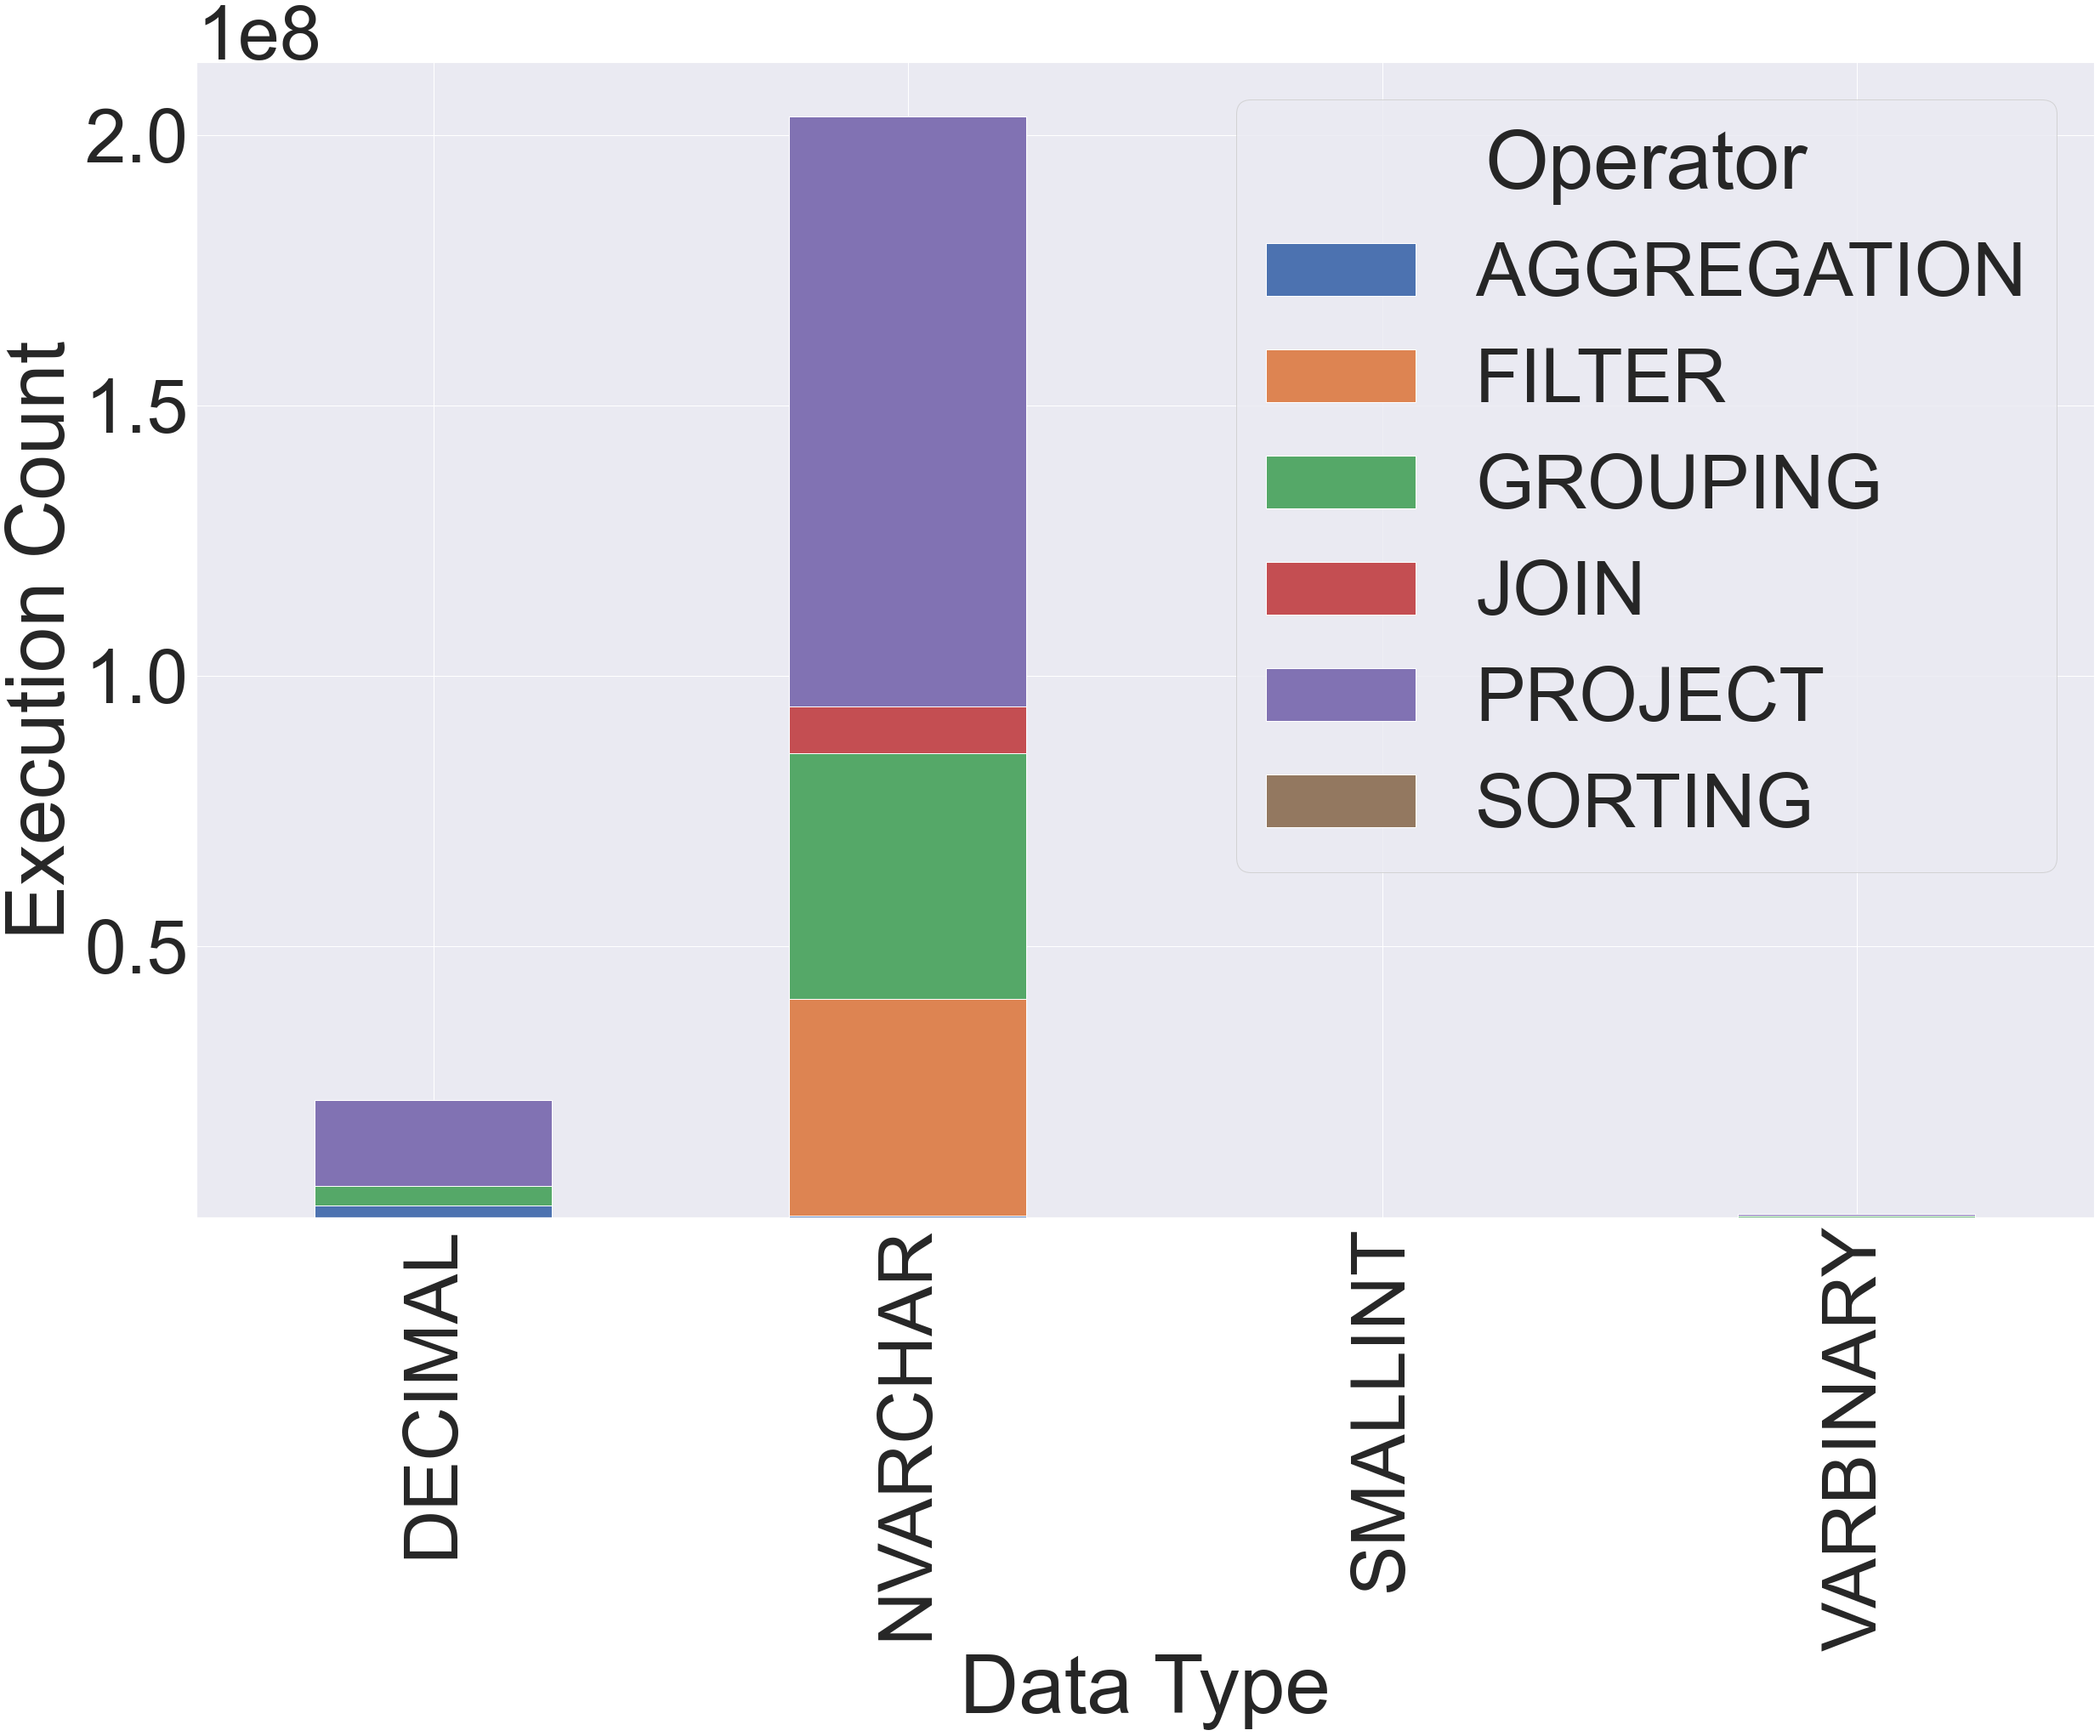

In [15]:
operation_per_type: DataFrame = with_type_info.groupby([OPERATOR, DATA_TYPE], as_index=False)[EXECUTION_COUNT].sum()
plot_stacked(data=operation_per_type, x=DATA_TYPE, y=EXECUTION_COUNT, hue=OPERATOR)
plt.savefig("visualizations/sap_data_workload.svg", bbox_inches = "tight")

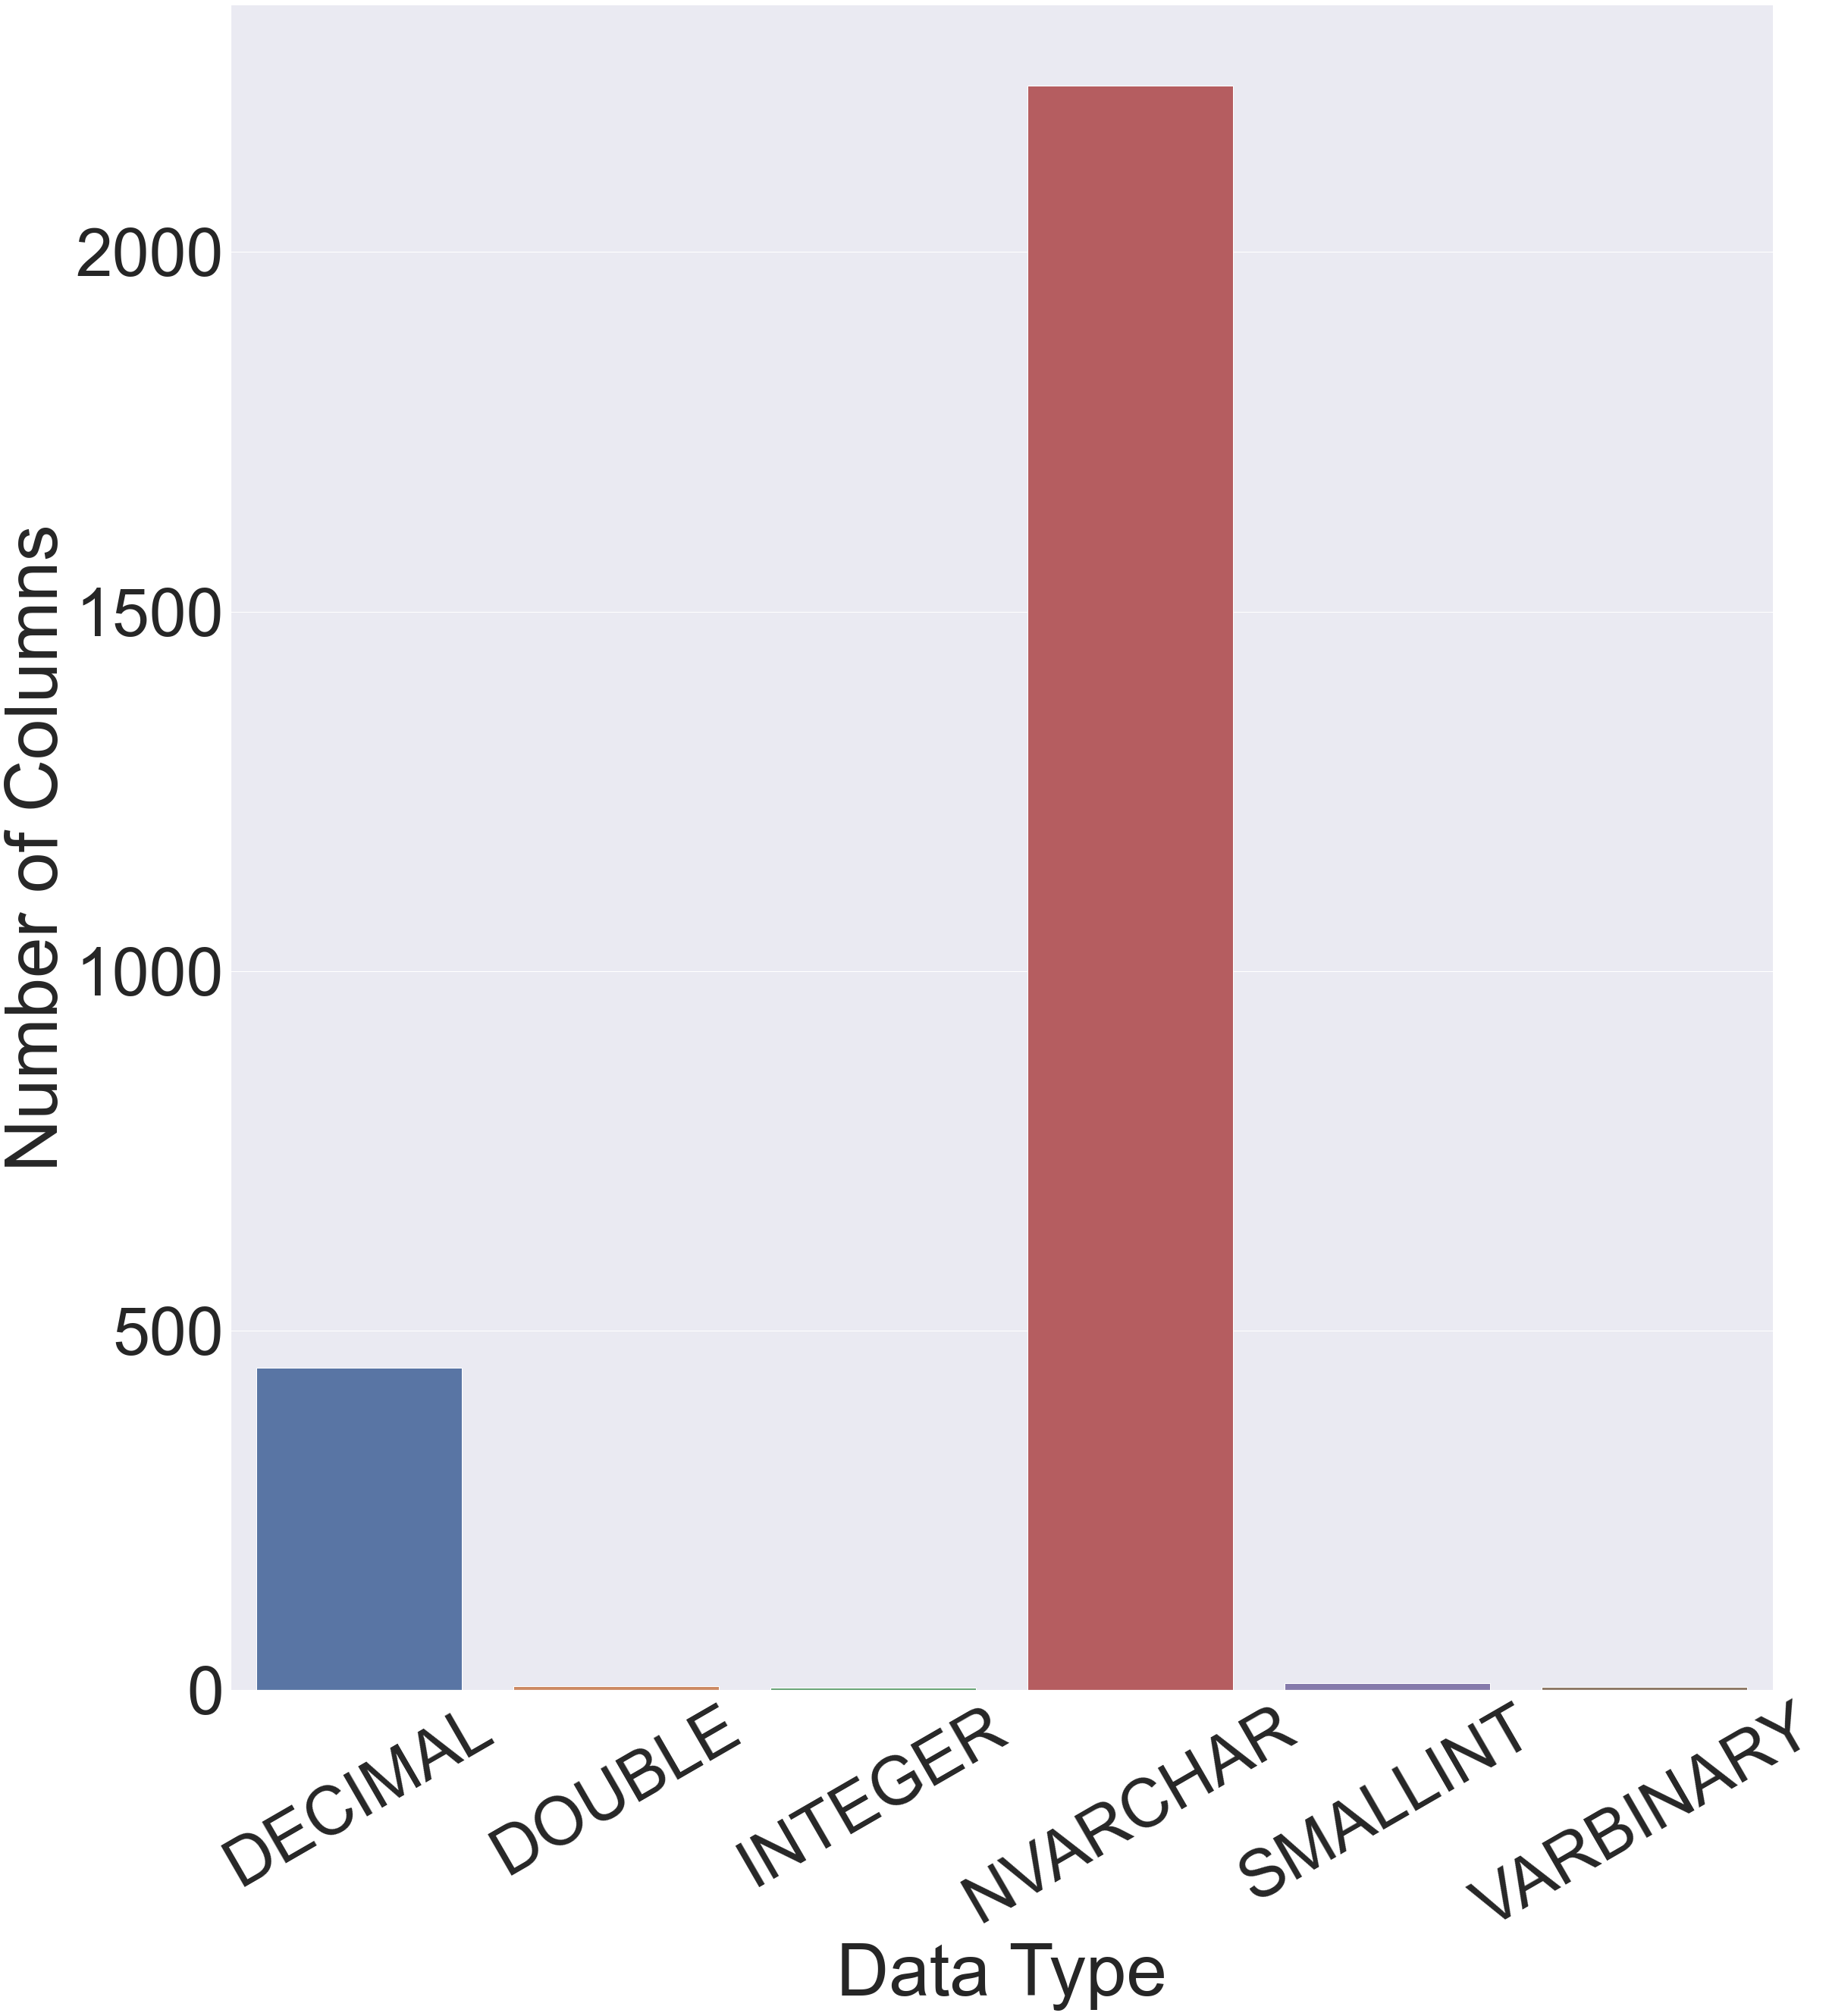

In [16]:
per_type: DataFrame = SAP_data.groupby([DATA_TYPE], as_index=False)[COUNT].count()
catplot = sns.catplot(data=per_type, x=DATA_TYPE, y=COUNT, kind="bar", height=35)
catplot.set_xticklabels(rotation=30)
catplot.savefig("visualizations/sap_data_type_sizes.png")

<Figure size 2160x1152 with 0 Axes>

In [19]:
operation_per_type: DataFrame = with_type_info.groupby([DATA_TYPE, TABLE_NAME, COLUMN_NAME, OPERATOR], as_index=False)[EXECUTION_COUNT].sum()
operation_per_type = operation_per_type[operation_per_type[OPERATOR] == "JOIN"]
sorted_by_execution_count = operation_per_type.sort_values([EXECUTION_COUNT])
sorted_by_execution_count.tail(10)

,Data Type,Table,Column,Operator,Execution Count
1014,NVARCHAR,COBK,BELNR,JOIN,239203
1418,NVARCHAR,PRPS,POSID,JOIN,347162
600,NVARCHAR,ACDOCA,PS_POSID,JOIN,347162
1434,NVARCHAR,T006,MSEHI,JOIN,349578
1143,NVARCHAR,COEP,MEINH,JOIN,349578
1140,NVARCHAR,COEP,MEINB,JOIN,349578
1361,NVARCHAR,FINSC_LD_CMP,BUKRS,JOIN,427362
1387,NVARCHAR,FINSC_LD_CMP,RLDNR,JOIN,613149
631,NVARCHAR,ACDOCA,RBUKRS,JOIN,654227
690,NVARCHAR,ACDOCA,RLDNR,JOIN,723223


In [ ]:
column_accesses

In [ ]:
test = with_type_info[(with_type_info[COLUMN_NAME].str.endswith("ID")) & (with_type_info[DATA_TYPE] != "NVARCHAR")]

In [25]:
SAP_data[CS_DATA_TYPE].drop_duplicates()

2452        FIXED
219193     DOUBLE
224944        INT
263045     STRING
2084027       RAW
Name: CS Data Type, dtype: object

In [28]:
SAP_data[SAP_data[COLUMN_NAME].str.contains("DATE")]

,Data Type,Column,Table,CS Data Type,Number of Columns
487340,NVARCHAR,CHANGEDATE,T000,STRING,1
611529,NVARCHAR,DATE_DET_POPER,T881,STRING,1
827607,NVARCHAR,FSH_CANDATE,VBAP,STRING,1
878330,NVARCHAR,HANDOVERDATE,VBAP,STRING,1
901488,NVARCHAR,ICR_ASSIGN_DATE,FBICRC003A,STRING,1
926406,NVARCHAR,INTDATE,BKPF,STRING,1
1047377,NVARCHAR,LAST_REORG_DATE,ANLA,STRING,1
1052012,NVARCHAR,LDT_DATE,ANLA,STRING,1
1407785,NVARCHAR,PDATE,KNA1,STRING,1
1592324,NVARCHAR,RGDATE,KNA1,STRING,1
